Data project:

CAPM - financial data

Choose 3 stocks and market (SP-500)
1. Data
- Import stock data from csv/api
- Merge stock data together
- Calculate expected return matrix
- Calculate covariance matrix

2. CAPM Regression
- Calculate stock regression.

![image.png](attachment:image.png)

- What is the market exposure/risk premium (Betas)
- Does CAPM hold? (Is alpha = 0)

3. CAPM: Portfolio
- Find Minimum variance portfolio and Efficient tangent portfolio (Highest sharpe ratio).
- Plot portfolios in volatility-return diagram.



In [140]:
import yfinance as yf
import pandas as pd
import numpy as np


# 1 Data

## 1.1) Importing data

In [141]:
#data = yf.download(["^GSPC", "BTC-USD", "META", "IVN.TO" ], start = "2020-01-01", end = "2024-04-08", interval = "1mo")
#data = data.iloc[:, :2]

data = yf.download(["^GSPC", "NVO", "MSFT", "META"], start = "2019-12-01", end = "2024-04-11", interval = "1mo")
#Hvis vi bare downloader data uden at specificere at det er Adjusted Close, så får vi en masse vi ikke skal bruge
data = data['Adj Close']
data['sp500_returns'] = data['^GSPC'].pct_change() * 100
data["NVO_returns"] = data["NVO"].pct_change() * 100
data["MSFT_returns"] = data["MSFT"].pct_change() * 100
data["META_returns"] = data["META"].pct_change() * 100
data = data.dropna()

print(data.tail())

[*********************100%%**********************]  4 of 4 completed

Ticker            META        MSFT         NVO        ^GSPC  sp500_returns  \
Date                                                                         
2023-12-01  353.584839  375.345886  102.708961  4769.830078       4.422923   
2024-01-01  389.726501  396.846130  113.918091  4845.649902       1.589571   
2024-02-01  489.610535  412.876495  118.912056  5096.270020       5.172064   
2024-03-01  485.579987  420.720001  127.480232  5254.350098       3.101878   
2024-04-01  519.830017  427.929993  125.400002  5160.640137      -1.783474   

Ticker      NVO_returns  MSFT_returns  META_returns  
Date                                                 
2023-12-01     1.580909     -0.556011      8.195018  
2024-01-01    10.913487      5.728115     10.221497  
2024-02-01     4.383821      4.039441     25.629264  
2024-03-01     7.205473      1.899722     -0.823215  
2024-04-01    -1.631806      1.713727      7.053427  


In [142]:
#returns = data.iloc[:, [4,5,6,7]] #betyder alle rækker, og kolonne 4,5,6,7. husk at 0,1,2,3,4,5,6,7
returns = data.loc[:,['NVO_returns', 'MSFT_returns', 'META_returns']]
return_matrix = np.mean(returns, axis=0)
print(return_matrix)
variance_matrix = np.var(returns, axis=0, ddof=1)
# We set the Delta Degrees of Freedom paramter to 1, such that it calculates the sample variance, so it matches the variance in the covariance matrix.
print(variance_matrix)

Ticker
NVO_returns     3.155456
MSFT_returns    2.217666
META_returns    2.595073
dtype: float64
Ticker
NVO_returns      35.962923
MSFT_returns     42.481255
META_returns    154.517799
dtype: float64


In [143]:
cov_matrix = returns.cov()
print(cov_matrix)
print("\n")

print(np.sqrt(cov_matrix))

Ticker        NVO_returns  MSFT_returns  META_returns
Ticker                                               
NVO_returns     35.962923     20.112426     10.340924
MSFT_returns    20.112426     42.481255     43.218824
META_returns    10.340924     43.218824    154.517799


Ticker        NVO_returns  MSFT_returns  META_returns
Ticker                                               
NVO_returns      5.996909      4.484688      3.215731
MSFT_returns     4.484688      6.517765      6.574103
META_returns     3.215731      6.574103     12.430519


## 2 Portfolios

In [144]:
# Define portfolio function, which returns ER and Volatility for any portfolio weight x
def portfolio(return_matrix, cov_matrix, w1,w2):
    W = pd.DataFrame([w1,w2, 1-w1-w2], index=['NVO_returns','MSFT_returns','META_returns'])
    tW = W.transpose()
    var = tW.dot(cov_matrix).dot(W)
    sd = np.sqrt(var)[0][0]

    e_r = tW.dot(return_matrix)[0]

   # print(tW)
   #print(W)
    #print(var)
    #print(sd)
    return e_r, sd



In [145]:
er, sd = portfolio(return_matrix, cov_matrix, 0,0)

print(f'Expected return = {er:.3f}, Volatility (standard deviation) = {sd:.3f}')

Expected return = 2.595, Volatility (standard deviation) = 12.431


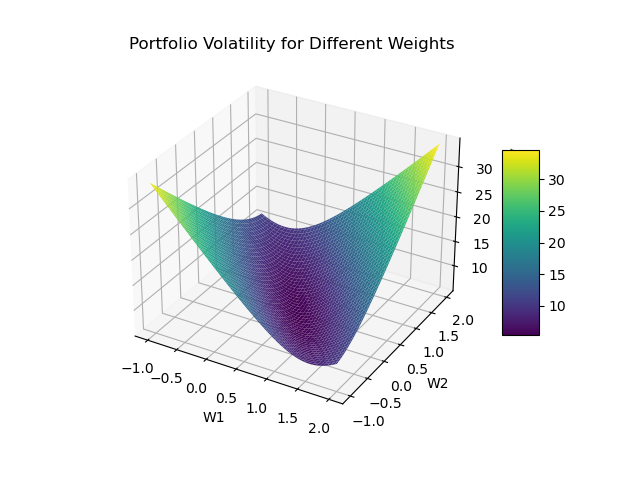

In [146]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib widget

# Define the function - Ensure your portfolio function is defined

# Generate the values for w1 and w2
w1_values = np.linspace(-1, 2, 100)  # Smaller number for simplicity
w2_values = np.linspace(-1, 2, 100)  # Smaller number for simplicity

# Create meshgrid for w1 and w2
W1, W2 = np.meshgrid(w1_values, w2_values)

# Initialize an array to hold the function values
function_values = np.zeros(W1.shape)

# Calculate the function values for each (w1, w2) pair
for i in range(W1.shape[0]):
    for j in range(W1.shape[1]):
        w1 = W1[i, j]
        w2 = W2[i, j]
        w3 = 1 - w1 - w2  # Ensure the sum of weights is 1
        # Adjust the line below if your portfolio function expects a different format
        function_values[i, j] = portfolio(return_matrix, cov_matrix, w1, w2)[1]

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(W1, W2, function_values, cmap='viridis')

# Add labels and title
ax.set_xlabel('W1')
ax.set_ylabel('W2')
ax.set_zlabel('Portfolio Volatility')
plt.title('Portfolio Volatility for Different Weights')

# Add a color bar which maps values to colors
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()


# 2.1 Minimum Variance Portfolio

In [147]:
def mvp(return_matrix, cov_matrix, N):
    N = N
    w1_vec = np.linspace(-1, 2, N)
    w2_vec = np.linspace(-1, 2, N)
    vol_best = np.inf
    w1_best = 0
    w2_best = 0
    for w1 in w1_vec:
        for w2 in w2_vec: 
            vol = portfolio(return_matrix, cov_matrix, w1, w2)[1]
            if vol < vol_best:
                vol_best = vol
                w1_best = w1
                w2_best = w2
    return w1_best, w2_best

w1_min, w2_min = mvp(return_matrix, cov_matrix, 100)

print(f'Minimum variance weights: w1 = {w1_min:.3f}, w2 = {w2_min:.3f}, w3 = {1-w1_min-w2_min:.3f}')

#print(f'Minimum variance weights: w1 = {w_min:.3f}, w2 = {1 - w_min:.3f}')

Minimum variance weights: w1 = 0.606, w2 = 0.333, w3 = 0.061


In [148]:
mvp = portfolio(return_matrix, cov_matrix, 0.091, 0.576)
print(f'MVP return = {mvp[0]:.3f}, MVP volatility = {mvp[1]:.3f}')

MVP return = 2.429, MVP volatility = 7.130


# 2.2 Efficient Tangent Portfolio

In [149]:
def sharpe_ratio(w1, w2, portfolio, rf = 0):
    '''Calculate the sharpe ratio for any portfolio'''

    rf = rf # Risk free rate
    e_r, sd = portfolio(return_matrix, cov_matrix, w1, w2) # Expected return and volatility

    sharpe = (e_r - rf)/sd
    return sharpe

In [150]:
def etp_w(N, portfolio):
    '''Calculates Efficient Tangent Portfolio by finding the highest Sharpe ratio'''

    # Create linear weight vector
    N = N
    w1_vec = np.linspace(-1, 2, N)
    w2_vec = np.linspace(-1, 2, N)

    # Initial best volatility and weight
    sharpe_best = -np.inf
    w1_best = 0
    w2_best = 0

    # Loops over all weight and saves the weight if the volatility is lower than before
    for w1 in w1_vec:
        for w2 in w2_vec:
            sharpe = sharpe_ratio(w1, w2, portfolio)
            if sharpe > sharpe_best:
                sharpe_best = sharpe
                w1_best = w1
                w2_best = w2
    return w1_best, w2_best

In [151]:
w1_etp, w2_etp = etp_w(100, portfolio)
print(f'Efficient tangent portfolio weights: w1 = {w1_etp:.3f}, w2 = {w2_etp:.3f} and w3 = {1-w1_etp-w2_etp:.3f}\n')


Efficient tangent portfolio weights: w1 = 0.879, w2 = 0.000 and w3 = 0.121



In [152]:
etp = portfolio(return_matrix, cov_matrix, w1_etp, w2_etp)
print(f'ETP return = {etp[0]:.3f}, ETP volatility = {etp[1]:.3f}')

ETP return = 3.088, ETP volatility = 5.679


# Plot mangler

In [128]:
def plot_sharp(portfolio):
    '''Plots Sharpe ratios and the efficient tangent portfolio'''

    # Generate the values for x, y, and z
    w1_values = np.linspace(-1, 2, 100)  # Varying values for the third input
    w2_values = np.linspace(-1, 2, 100)  # Varying values for the third input

    # Create a figure and axis
    fig, ax = plt.subplots()

    # Plot the values of the function for each z value
    function_values = []

    for w1 in w1_values:
        for w2 in w2_values:
            # Calculate the function values
            function_values.append(sharpe_ratio(w1, w2, portfolio)) 
    
    # Calculate ETP
    w_etp = etp_w(100, portfolio)

    ax.plot(w1_values, function_values, label = "sharpe ratio")
    ax.scatter(w_etp, sharpe_ratio(w_etp, portfolio), c = "red", label = "efficient tangent portfolio")

    # Add labels and a legend
    ax.set_xlabel('weight')
    ax.set_ylabel('Sharpe ratio')
    ax.legend()

    ax.set_xlim(-1, 2)
    plt.show()

ValueError: x and y must have same first dimension, but have shapes (100,) and (10000,)

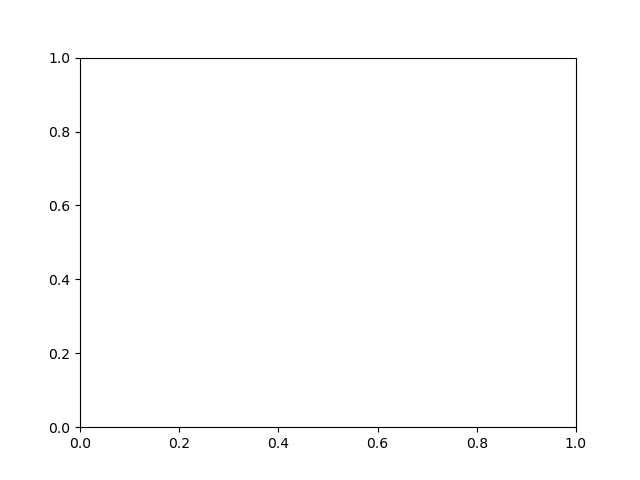

In [129]:
plot_sharp(portfolio)

## 2.3 Efficient market frontier

In [153]:
# Weights for the MVP and ETP
mvp_weights = pd.DataFrame([w1_min, w2_min, 1 - w1_min - w2_min])
etp_weights = pd.DataFrame([w1_etp, w2_etp, 1 - w1_etp - w2_etp])

# Creating y_vec and lin_vec to store linear combinations
y_vec = np.linspace(-3, 3, 100)
lin_vec = []

for y in y_vec:
    linear = y*mvp_weights + (1-y)*etp_weights
    lin_vec.append(linear[0][0])

In [154]:
def plot_capm(mvp, etp, lin_vec, portfolio):
    '''Plots the efficient frontier and the capital market line'''
    fig, ax = plt.subplots()

    # Empty vector to store frontier
    frontier = []

    for l in lin_vec:
        # Calculate the function values
        frontier.append(portfolio(return_matrix, cov_matrix, w1, w2)) 
        
    return_values, vol_values = zip(*frontier)

    rf = 0
    point_rf = [0, rf]
    point_etp = [etp[1], etp[0]]

    # Compute the equation of the line passing through the two points
    # y = mx + c, where m is the slope and c is the y-intercept
    slope = (point_etp[1] - point_rf[1]) / (point_etp[0] - point_rf[0])
    y_intercept = point_rf[1] - slope * point_rf[0]

    # Generate x values for the line
    x_values = np.linspace(0, 10, 100)
    # Compute corresponding y values
    y_values = slope * x_values + y_intercept

    # Plot the points and the line passing through them
    plt.plot(x_values, y_values, label='Capital market line', linewidth = 0.5, color = "black")


    ax.plot(vol_values, return_values, label = "efficient frontier")
    #ax.scatter(0, rf, label = "risk free")
    ax.scatter(mvp[1], mvp[0], c = "green", label = "minimum variance portfolio")
    ax.scatter(etp[1], etp[0], c = "red", label = "efficient tangent portfolio")

    # Add labels and a legend
    ax.set_xlabel('volatility')
    ax.set_ylabel('return')
    ax.legend()

    ax.set_xlim(0, 10)
    ax.set_ylim(0, 5)
    plt.show()

TypeError: 'function' object is not subscriptable

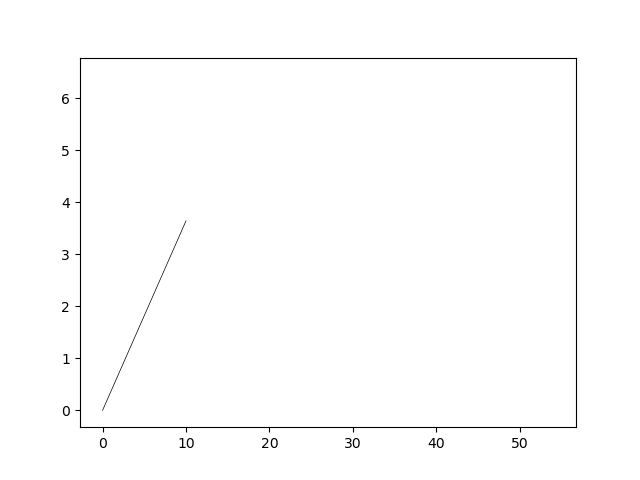

In [135]:
plot_capm(mvp, etp, lin_vec, portfolio)